In [10]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO
from pathlib    import Path
from sklearn.metrics import confusion_matrix, classification_report

# Paths
MODEL_PATH   = Path("models")/"emotion_detector"/"weights"/"best.pt"
TEST_IMG_DIR = Path("../data")/"processed"/"test"/"images"
TEST_LBL_DIR = Path("../data")/"processed"/"test"/"labels"

# Load class names from data.yaml
import yaml
data_cfg = yaml.safe_load(Path("data.yaml").read_text())
NAMES = data_cfg["names"]  # ['angry', 'contempt', …]


In [ ]:
model = YOLO(str(MODEL_PATH))
print("✅ Model loaded:", MODEL_PATH)


✅ Model loaded: models\emotion_detector\weights\best.pt


In [7]:
res = model.val(data=DATA_FILE, split="test", verbose=False)
print(res)  # aggregate metrics again

Ultralytics 8.3.43  Python-3.8.20 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 168 layers, 3,007,403 parameters, 0 gradients


val: Scanning C:\Users\mrosk\OneDrive\Desktop\emotion-detection-yolo\data\processed\test\labels.cache... 1164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1164/1164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.64it/s]


                   all       1164       1164       0.67        0.7      0.722      0.523
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019B040019A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

In [11]:
img_paths = sorted(TEST_IMG_DIR.glob("*.*"))
y_true = []

for img_p in img_paths:
    lbl_p = TEST_LBL_DIR / f"{img_p.stem}.txt"
    # each .txt has: class x_center y_center w h
    with open(lbl_p, "r") as f:
        cls = int(f.readline().split()[0])
    y_true.append(cls)

print(f"Found {len(y_true)} ground-truth labels.")


Found 1164 ground-truth labels.


In [12]:
y_pred = []

# You can tune conf and iou thresholds if you like:
for img_p in img_paths:
    # run a single-image inference
    res = model.predict(str(img_p), conf=0.25, iou=0.45, verbose=False)
    boxes = res[0].boxes  # this is a ResultsBox object
    if len(boxes) == 0:
        # no face detected → treat as “background” or wrong
        y_pred.append(-1)
    else:
        # pick the detection with highest confidence
        confidences = boxes.conf.cpu().numpy()
        classes     = boxes.cls.cpu().numpy().astype(int)
        top = confidences.argmax()
        y_pred.append(int(classes[top]))

print(f"Inferred {len(y_pred)} predictions.")


Inferred 1164 predictions.


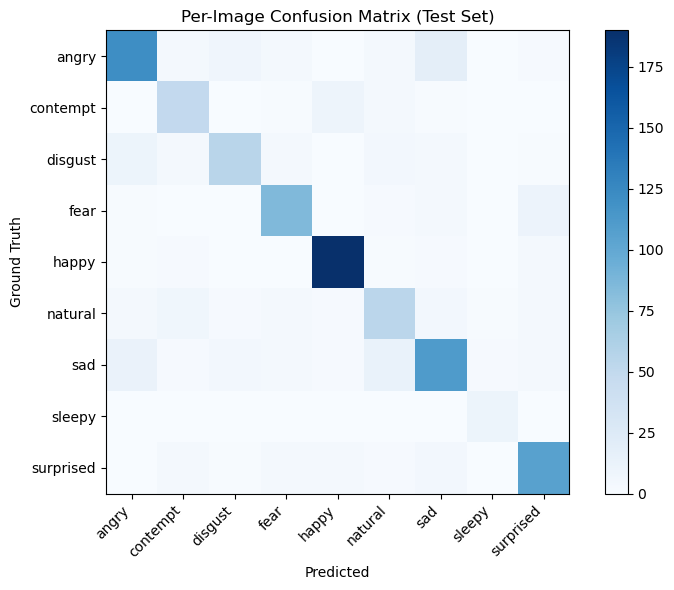

In [14]:
%matplotlib inline
# Filter out “no detection” if desired:
mask = [p >= 0 for p in y_pred]
y_true_f, y_pred_f = np.array(y_true)[mask], np.array(y_pred)[mask]

cm = confusion_matrix(y_true_f, y_pred_f, labels=list(range(len(NAMES))))

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(NAMES)))
ax.set_xticklabels(NAMES, rotation=45, ha="right")
ax.set_yticks(range(len(NAMES)))
ax.set_yticklabels(NAMES)
ax.set_xlabel("Predicted")
ax.set_ylabel("Ground Truth")
plt.title("Per-Image Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [15]:
print("Classification Report:\n")
print(classification_report(
    y_true_f, y_pred_f,
    target_names=NAMES,
    digits=3
))


Classification Report:

              precision    recall  f1-score   support

       angry      0.818     0.756     0.786       160
    contempt      0.710     0.766     0.737        64
     disgust      0.775     0.671     0.719        82
        fear      0.817     0.833     0.825       102
       happy      0.922     0.955     0.938       199
     natural      0.635     0.667     0.651        81
         sad      0.745     0.725     0.735       153
      sleepy      0.769     1.000     0.870        10
   surprised      0.815     0.855     0.835       124

    accuracy                          0.801       975
   macro avg      0.779     0.803     0.788       975
weighted avg      0.801     0.801     0.800       975



In [17]:
# === Method 1: detailed Ultralytics val() metrics ===
res = model.val(data="data.yaml", split="test", verbose=False)

# 1) Overall aggregates
print("=== Overall metrics (results_dict) ===")
for k,v in res.results_dict.items():
    print(f"{k:20s}: {v:.4f}")

# 2) Per-class mAP50–95
print("\n=== Per-class mAP50–95 (res.maps) ===")
# res.names is a dict: {0:'angry',1:'contempt',...}
for idx, ap in enumerate(res.maps):
    print(f"{res.names[idx]:12s}: {ap:.4f}")

# 3) Speed breakdown
print("\n=== Speed (ms per image) ===")
for stage,t in res.speed.items():
    print(f"{stage:12s}: {t*1000:7.1f} ms")

print(f"\nMetrics saved under: {res.save_dir}")


Ultralytics 8.3.43  Python-3.8.20 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)


val: Scanning C:\Users\mrosk\OneDrive\Desktop\emotion-detection-yolo\data\processed\test\labels.cache... 1164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1164/1164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.57it/s]


                   all       1164       1164       0.67        0.7      0.722      0.523
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val4
=== Overall metrics (results_dict) ===
metrics/precision(B): 0.6697
metrics/recall(B)   : 0.7001
metrics/mAP50(B)    : 0.7219
metrics/mAP50-95(B) : 0.5229
fitness             : 0.5428

=== Per-class mAP50–95 (res.maps) ===
angry       : 0.5418
contempt    : 0.5747
disgust     : 0.6575
fear        : 0.6646
happy       : 0.5788
natural     : 0.4263
sad         : 0.4511
sleepy      : 0.2376
surprised   : 0.5736

=== Speed (ms per image) ===
preprocess  :   258.1 ms
inference   :  3330.5 ms
loss        :     0.0 ms
postprocess :  1402.4 ms

Metrics saved under: runs\detect\val4


In [23]:
import numpy as np
from sklearn.metrics import classification_report

print("\n=== Manual per-image inference ===")
y_true, y_pred = [], []

# 1) Load ground-truth labels
for img_p in sorted(TEST_IMG_DIR.glob("*.*")):
    # build the .txt path correctly:
    lbl_p = TEST_LBL_DIR / f"{img_p.stem}.txt"
    with open(lbl_p, "r") as f:
        cls = int(f.readline().split()[0])
    y_true.append(cls)

# 2) Run inference one image at a time
for img_p in sorted(TEST_IMG_DIR.glob("*.*")):
    r = model.predict(
        str(img_p),
        conf=0.25,
        iou=0.45,
        verbose=False
    )[0]

    if len(r.boxes) == 0:
        y_pred.append(-1)  # no detection
    else:
        confs = r.boxes.conf.cpu().numpy()
        clss  = r.boxes.cls.cpu().numpy().astype(int)
        top   = confs.argmax()
        y_pred.append(int(clss[top]))

# 3) Filter out “no detection” cases (if you want pure 1-to-1 comparison)
mask = np.array(y_pred) >= 0
y_true_f, y_pred_f = np.array(y_true)[mask], np.array(y_pred)[mask]

# 4) Print classification report
print(classification_report(
    y_true_f,
    y_pred_f,
    target_names=NAMES,
    digits=3
))



=== Manual per-image inference ===
              precision    recall  f1-score   support

       angry      0.818     0.756     0.786       160
    contempt      0.710     0.766     0.737        64
     disgust      0.775     0.671     0.719        82
        fear      0.817     0.833     0.825       102
       happy      0.922     0.955     0.938       199
     natural      0.635     0.667     0.651        81
         sad      0.745     0.725     0.735       153
      sleepy      0.769     1.000     0.870        10
   surprised      0.815     0.855     0.835       124

    accuracy                          0.801       975
   macro avg      0.779     0.803     0.788       975
weighted avg      0.801     0.801     0.800       975



In [25]:

print("Val() mAP50-95:", val_results.results_dict['metrics/mAP50-95(B)'])
from sklearn.metrics import average_precision_score

# compute per-class AP50 manually? (skip for brevity)
print("Manual F1 (macro):", classification_report(y_true_f,y_pred_f,output_dict=True)['macro avg']['f1-score'])
print("Manual accuracy:", (y_true_f==y_pred_f).mean())


Val() mAP50-95: 0.5228947973084567
Manual F1 (macro): 0.788326399644208
Manual accuracy: 0.801025641025641
